In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import math, os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from random import randint
from sklearn.datasets import fetch_mldata


## Network Definitions

In [2]:
'''
Overarching Model
'''

class CapsNet(nn.Module):
    def __init__(self, routing_iterations, 
                 preCapDepth, numCaps, numPerCap, capFilterSize,
                c1kernelSizes, c1kernelStrides, c1numMaps, n_classes=10):
        super(CapsNet, self).__init__()
        self.preCapDepth = preCapDepth
        self.numCaps = numCaps
        self.numPerCap = numPerCap
        self.c1kernelSizes = c1kernelSizes
        self.c1kernelStrides = c1kernelStrides
        self.c1numMaps = c1numMaps
        
        #self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.conv1 = PrimaryConvs(self.c1kernelSizes, self.c1kernelStrides,self.c1numMaps)
        
        #self.primaryCaps = PrimaryCapsLayer(self.preCapDepth, self.m=numCaps, self.numPerCap, kernel_size=9, stride=2)  # outputs: normalized sheets
        self.primaryCaps = PrimaryCapsLayer(self.preCapDepth, self.numCaps, self.numPerCap)
        
        self.num_primaryCaps = numCaps * (capFilterSize**2)
        routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
        self.digitCaps = CapsLayer(self.num_primaryCaps, self.numPerCap, n_classes, 16, routing_module)

    def forward(self, input):
        x = self.conv1(input)
        x = self.primaryCaps(x) # output sheet
        x = self.digitCaps(x) # output score matrix (before final flat)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs

### Input Networks

In [3]:
'''
Input: FM after 1st convolution
Output: Normalized sheet
'''
class PrimaryCapsLayer(nn.Module):
    def __init__(self, input_channels, output_caps, output_dim):
        super(PrimaryCapsLayer, self).__init__()
        #self.conv = nn.Conv2d(input_channels, output_caps * output_dim, kernel_size=kernel_size, stride=stride)
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        #out = self.conv(input)
        out = input
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W) # splitting into capsules

        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous() 
        out = out.view(out.size(0), -1, out.size(4)) # flat N*sheet
        out = squash(out) # normalize
        return out
    
'''
Input: FM after 1st convolution
Output: Normalized sheet
'''
class PrimaryConvs(nn.Module):
    def __init__(self, c1kernelSizes, c1kernelStrides, c1numMaps):
        super(PrimaryConvs, self).__init__()
        self.c1kernelSizes = c1kernelSizes
        self.c1kernelStrides = c1kernelStrides
        self.c1numMaps = c1numMaps
        self.numLayers = len(c1numMaps)
        
        self.conv1 = None
        if self.numLayers >= 1:
            self.conv1 = nn.Conv2d(3, self.c1numMaps[0], 
                                   kernel_size=self.c1kernelSizes[0], 
                                   stride=self.c1kernelStrides[0])
        self.conv2 = None
        if self.numLayers >= 2:
            self.conv2 = nn.Conv2d(self.c1numMaps[0], self.c1numMaps[1], 
                                   kernel_size=self.c1kernelSizes[1], 
                                   stride=self.c1kernelStrides[1])
        self.conv3 = None
        if self.numLayers >= 3:
            self.conv3 = nn.Conv2d(self.c1numMaps[1], self.c1numMaps[2], 
                                   kernel_size=self.c1kernelSizes[2], 
                                   stride=self.c1kernelStrides[2])
        self.conv4 = None
        if self.numLayers >= 4:
            self.conv4 = nn.Conv2d(self.c1numMaps[2], self.c1numMaps[3], 
                                   kernel_size=self.c1kernelSizes[3], 
                                   stride=self.c1kernelStrides[3])
    def forward(self, x):
        if self.conv1:
            x = self.conv1(x)
            if self.numLayers != 1:
                x = F.relu(x)
        if self.conv2:
            x = self.conv2(x)
            if self.numLayers != 2:
                x = F.relu(x)
        if self.conv3:
            x = self.conv3(x)
            if self.numLayers != 3:
                x = F.relu(x)
        if self.conv4:
            x = self.conv4(x)
            if self.numLayers != 4:
                x = F.relu(x)
        return x
        

In [4]:
def squash(x):
    lengths2 = x.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    x = x * (lengths2 / (1 + lengths2) / lengths).view(x.size(0), x.size(1), 1)
    return x


class AgreementRouting(nn.Module):
    def __init__(self, input_caps, output_caps, n_iterations):
        super(AgreementRouting, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()
        
        c = F.softmax(self.b)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)

        if self.n_iterations > 0:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
                s = (c * u_predict).sum(dim=1)
                v = squash(s)
        return v


class CapsLayer(nn.Module):
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(CapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(torch.Tensor(input_caps, input_dim, output_caps * output_dim))
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(u_predict.size(0), self.input_caps, self.output_caps, self.output_dim)
        v = self.routing_module(u_predict)
        return v


In [5]:
### Reconstruction Stuff 
class ReconstructionNet(nn.Module):
    def __init__(self, n_dim=16, n_classes=10):
        super(ReconstructionNet, self).__init__()
        self.fc1 = nn.Linear(n_dim * n_classes, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 32*32*3)
        self.n_dim = n_dim
        self.n_classes = n_classes

    def forward(self, x, target):
        mask = Variable(torch.zeros((x.size()[0], self.n_classes)), requires_grad=False)
        if next(self.parameters()).is_cuda:
            mask = mask.cuda()
        mask.scatter_(1, target.view(-1, 1), 1.)
        mask = mask.unsqueeze(2)
        x = x * mask
        x = x.view(-1, self.n_dim * self.n_classes)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x


class CapsNetWithReconstruction(nn.Module):
    def __init__(self, capsnet, reconstruction_net):
        super(CapsNetWithReconstruction, self).__init__()
        self.capsnet = capsnet
        self.reconstruction_net = reconstruction_net

    def forward(self, x, target):
        x, probs = self.capsnet(x)
        reconstruction = self.reconstruction_net(x, target)
        return reconstruction, probs

## Train

### Helper functions

In [6]:
### Define Loss Functions
class MarginLoss(nn.Module):
    def __init__(self, m_pos, m_neg, lambda_):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, lengths, targets, size_average=True):
        t = torch.zeros(lengths.size()).long()
        if targets.is_cuda:
            t = t.cuda()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = Variable(t)
        losses = targets.float() * F.relu(self.m_pos - lengths).pow(2) + \
                 self.lambda_ * (1. - targets.float()) * F.relu(lengths - self.m_neg).pow(2)
        return losses.mean() if size_average else losses.sum()

### save model
def saveModel(model,name,state_dict=False):
    if state_dict:
        torch.save(model.state_dict(),name)
    else:
        torch.save(model,name)


### rotation transform class
class RandomRotation(object):
    def __init__(self, degrees_tup):
        self.dt = [0]*6
        self.dt[degrees_tup] = 1

    def __call__(self, sample):
        
        if self.dt[0]:
            return sample
        sample = np.asarray(sample)
       
        if self.dt[0]:
            sample = rotate(randint(0, 1),sample)
            return np2PIL(sample)
        if self.dt[1]:
            sample = rotate(randint(0, 1)*2,sample)
            return np2PIL(sample)
        if self.dt[2]:
            sample = rotate(randint(0, 1)*3,sample)
            return np2PIL(sample)
        if self.dt[3]:
            sample = rotate(randint(1, 3),sample)
            return np2PIL(sample)
        if self.dt[4]:
            sample = rotate(randint(0, 3),sample)
            return np2PIL(sample)
def np2PIL(data):
    return Image.fromarray(data)
def rotate(i,data):
    if i == 0:
        return data
    elif i == 1:
        return np.rot90(data)
    elif i == 2:
        return np.rot90(data,2)
    elif i == 3:
        return np.rot90(data,3)
    
### Normalize
def normalize(tensorData):
    return torch.Tensor(tensorData.numpy()/255.)

In [7]:
def train(Epoch,Loss,numStatsPerEpoch,Rec_loss_every=1):
    model.train()
    statIdx = [len(TRAINLOADER)/numStatsPerEpoch]*numStatsPerEpoch
    statIdx = [(i)*a for i,a in enumerate(statIdx)]
    for batch_idx, (data, target) in enumerate(TRAINLOADER):
        
        # get stats
        if (batch_idx) in statIdx:
            test_loss, test_acc,TN,TD = getLossAccND('Test',TESTLOADER)
            print
            TestLoss.append(test_loss);TestAcc.append(test_acc);
    
        # train
        data = data.view(-1,3,32,32)
        data, target = data.float(), target.long()
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        if RECONSTRUCTION:
            output, probs = model(data, target)
            print output.size(), probs.size(), data.size(), target.size()
            reconstruction_loss = F.mse_loss(output, data.view(-1, 32*32*3))
            margin_loss = loss_fn(probs, target)
            loss = reconstruction_alpha * reconstruction_loss + margin_loss
        else:
            output, probs = model(data)
            loss = loss_fn(probs, target)
        
        if batch_idx % Rec_loss_every == 0:
            Loss.append(loss.data[0])
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INT == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                Epoch, batch_idx * len(data), len(TRAINLOADER.dataset),
                       100. * batch_idx / len(TRAINLOADER), loss.data[0]))

def getLossAccND(name,dataloader):
    model.eval()
    loss = 0
    correct = 0
    for data, target in dataloader:
        data = data.view(-1,3,32,32)
        data, target = data.float(), target.long()
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        #print data, target
        if RECONSTRUCTION:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 32*32*3), size_average=False).data[0]
            loss += loss_fn(probs, target, size_average=False).data[0]
            loss += reconstruction_alpha * reconstruction_loss
        else:
            output, probs = model(data)
            loss += loss_fn(probs, target, size_average=False).data[0]

        pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(dataloader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        name,loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    return (loss, 100. * correct / len(dataloader.dataset), correct, len(dataloader.dataset))

### Defining paramters, loaders, SGD elements

In [11]:
# # Training settings
# parser = argparse.ArgumentParser(description='CapsNet with MNIST')
# parser.add_argument('--batch-size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 64)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=250, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
#                     help='learning rate (default: 0.01)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# parser.add_argument('--routing_iterations', type=int, default=3)
# parser.add_argument('--with_reconstruction', action='store_true', default=False)
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

### Model Architecture Params
ROUTING_ITERS = 3
CONVKERNELSIZES, CONVKERNELSTRIDES, CONVNUMMAPS = \
    [7,7,5],[1,1,2],[256,256,256]
PRECAPDEPTH = CONVNUMMAPS[-1]
NUMCAPS = 64 
NUMPERCAP = 4  #Note: precapdepth=numcaps*numpercap
CAPFILTERSIZE = 8
INPUT_SIZE, INPUT_DIM = 32,3


### Training Params
BATCH_SIZE = 60
TEST_BATCH_SIZE = 200
EPOCHS = 12
LEARNING_RATE = 0.002
DECAY_EPOCH = 3
CUDA = torch.cuda.is_available()
SEED = 1
LOG_INT = 10 # how many batches to wait before logging training status
RECONSTRUCTION = True
ROTATION_TYPE = 3
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

### Stats
NUMSTATSPEREPOCH = 4


TRAINLOADER = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True,
                   transform=transforms.Compose([
                        transforms.ToTensor()
                    ])),
    batch_size=TEST_BATCH_SIZE, shuffle=False)

model = CapsNet(ROUTING_ITERS,
                PRECAPDEPTH, NUMCAPS, NUMPERCAP, CAPFILTERSIZE,
                CONVKERNELSIZES,CONVKERNELSTRIDES,CONVNUMMAPS,
                n_classes=10)
#model = CapsNet( ROUTING_ITERS,PRECAPDEPTH, NUMCAPS, NUMPERCAP, CAPFILTERSIZE,
#               CONVKERNELSIZES, CONVKERNELSTRIDES, CONVNUMMAPS )

if RECONSTRUCTION:
    reconstruction_model = ReconstructionNet(16, 10)
    reconstruction_alpha = 0.0005
    model = CapsNetWithReconstruction(model, reconstruction_model)

if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,4)
loss_fn = MarginLoss(0.9, 0.1, 0.5)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
### Call training functions 
TrainLoss = []; TrainL_every = 1; TrN=0; TrD=0
TestLoss = []; TestAcc = []; TN=0; TD=0
for epoch in range(1, EPOCHS + 1):
    train(epoch,TrainLoss,NUMSTATSPEREPOCH,TrainL_every)
    scheduler.step()
    #scheduler.step(TestLoss[-1])

# get final training and testing stats
ftest_loss, ftest_acc,TN,TD = getLossAccND('Test',TESTLOADER)
ftrain_loss, ftrain_acc,TrN,TrD = getLossAccND('Train',TRAINLOADER)

Test set: Average loss: 0.9078, Accuracy: 1011/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.081026
Train Epoch: 1 [600/50000 (1%)]	Loss: 0.085376
Train Epoch: 1 [1200/50000 (2%)]	Loss: 0.064422
Train Epoch: 1 [1800/50000 (4%)]	Loss: 0.072669
Train Epoch: 1 [2400/50000 (5%)]	Loss: 0.062301
Train Epoch: 1 [3000/50000 (6%)]	Loss: 0.098956
Train Epoch: 1 [3600/50000 (7%)]	Loss: 0.097797
Train Epoch: 1 [4200/50000 (8%)]	Loss: 0.079676
Train Epoch: 1 [4800/50000 (10%)]	Loss: 0.064471
Train Epoch: 1 [5400/50000 (11%)]	Loss: 0.060655
Train Epoch: 1 [6000/50000 (12%)]	Loss: 0.076563
Train Epoch: 1 [6600/50000 (13%)]	Loss: 0.099771
Train Epoch: 1 [7200/50000 (14%)]	Loss: 0.061583
Train Epoch: 1 [7800/50000 (16%)]	Loss: 0.060322
Train Epoch: 1 [8400/50000 (17%)]	Loss: 0.075623
Train Epoch: 1 [9000/50000 (18%)]	Loss: 0.072626
Train Epoch: 1 [9600/50000 (19%)]	Loss: 0.066017
Train Epoch: 1 [10200/50000 (20%)]	Loss: 0.065610
Train Epoch: 1 [10800/50000 (22%)]	Loss: 0.060104
Train Epoch: 1 [114

Train Epoch: 2 [43200/50000 (86%)]	Loss: 0.048299
Train Epoch: 2 [43800/50000 (88%)]	Loss: 0.058607
Train Epoch: 2 [44400/50000 (89%)]	Loss: 0.053424
Train Epoch: 2 [45000/50000 (90%)]	Loss: 0.046225
Train Epoch: 2 [45600/50000 (91%)]	Loss: 0.046740
Train Epoch: 2 [46200/50000 (92%)]	Loss: 0.041044
Train Epoch: 2 [46800/50000 (94%)]	Loss: 0.035315
Train Epoch: 2 [47400/50000 (95%)]	Loss: 0.046489
Train Epoch: 2 [48000/50000 (96%)]	Loss: 0.044204
Train Epoch: 2 [48600/50000 (97%)]	Loss: 0.043271
Train Epoch: 2 [49200/50000 (98%)]	Loss: 0.043015
Train Epoch: 2 [49800/50000 (100%)]	Loss: 0.040932
Test set: Average loss: 0.5312, Accuracy: 3765/10000 (38%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.044770
Train Epoch: 3 [600/50000 (1%)]	Loss: 0.040589
Train Epoch: 3 [1200/50000 (2%)]	Loss: 0.040437
Train Epoch: 3 [1800/50000 (4%)]	Loss: 0.048325
Train Epoch: 3 [2400/50000 (5%)]	Loss: 0.048728
Train Epoch: 3 [3000/50000 (6%)]	Loss: 0.048133
Train Epoch: 3 [3600/50000 (7%)]	Loss: 0.037574
Train E

Train Epoch: 4 [36600/50000 (73%)]	Loss: 0.043143
Train Epoch: 4 [37200/50000 (74%)]	Loss: 0.038289
Test set: Average loss: 0.4999, Accuracy: 4558/10000 (46%)

Train Epoch: 4 [37800/50000 (76%)]	Loss: 0.041523
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.042593
Train Epoch: 4 [39000/50000 (78%)]	Loss: 0.040617
Train Epoch: 4 [39600/50000 (79%)]	Loss: 0.041632
Train Epoch: 4 [40200/50000 (80%)]	Loss: 0.033426
Train Epoch: 4 [40800/50000 (82%)]	Loss: 0.030572
Train Epoch: 4 [41400/50000 (83%)]	Loss: 0.030152
Train Epoch: 4 [42000/50000 (84%)]	Loss: 0.037663
Train Epoch: 4 [42600/50000 (85%)]	Loss: 0.032190
Train Epoch: 4 [43200/50000 (86%)]	Loss: 0.032579
Train Epoch: 4 [43800/50000 (88%)]	Loss: 0.034470
Train Epoch: 4 [44400/50000 (89%)]	Loss: 0.039726
Train Epoch: 4 [45000/50000 (90%)]	Loss: 0.039954
Train Epoch: 4 [45600/50000 (91%)]	Loss: 0.046070
Train Epoch: 4 [46200/50000 (92%)]	Loss: 0.040124
Train Epoch: 4 [46800/50000 (94%)]	Loss: 0.037035
Train Epoch: 4 [47400/50000 (95%)]	Loss:

Train Epoch: 6 [29400/50000 (59%)]	Loss: 0.025951
Train Epoch: 6 [30000/50000 (60%)]	Loss: 0.024207
Train Epoch: 6 [30600/50000 (61%)]	Loss: 0.029657
Train Epoch: 6 [31200/50000 (62%)]	Loss: 0.020300
Train Epoch: 6 [31800/50000 (64%)]	Loss: 0.023652
Train Epoch: 6 [32400/50000 (65%)]	Loss: 0.025316
Train Epoch: 6 [33000/50000 (66%)]	Loss: 0.025659
Train Epoch: 6 [33600/50000 (67%)]	Loss: 0.031062
Train Epoch: 6 [34200/50000 (68%)]	Loss: 0.027250
Train Epoch: 6 [34800/50000 (70%)]	Loss: 0.025739
Train Epoch: 6 [35400/50000 (71%)]	Loss: 0.030264
Train Epoch: 6 [36000/50000 (72%)]	Loss: 0.031731
Train Epoch: 6 [36600/50000 (73%)]	Loss: 0.025202
Train Epoch: 6 [37200/50000 (74%)]	Loss: 0.024691
Test set: Average loss: 0.3682, Accuracy: 6020/10000 (60%)

Train Epoch: 6 [37800/50000 (76%)]	Loss: 0.027543
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.022705
Train Epoch: 6 [39000/50000 (78%)]	Loss: 0.019999
Train Epoch: 6 [39600/50000 (79%)]	Loss: 0.024334
Train Epoch: 6 [40200/50000 (80%)]	Loss:

Train Epoch: 8 [22800/50000 (46%)]	Loss: 0.025021
Train Epoch: 8 [23400/50000 (47%)]	Loss: 0.025738
Train Epoch: 8 [24000/50000 (48%)]	Loss: 0.018431
Train Epoch: 8 [24600/50000 (49%)]	Loss: 0.025069
Test set: Average loss: 0.3623, Accuracy: 6115/10000 (61%)

Train Epoch: 8 [25200/50000 (50%)]	Loss: 0.025267
Train Epoch: 8 [25800/50000 (52%)]	Loss: 0.027288
Train Epoch: 8 [26400/50000 (53%)]	Loss: 0.026159
Train Epoch: 8 [27000/50000 (54%)]	Loss: 0.024775
Train Epoch: 8 [27600/50000 (55%)]	Loss: 0.023854
Train Epoch: 8 [28200/50000 (56%)]	Loss: 0.026733
Train Epoch: 8 [28800/50000 (58%)]	Loss: 0.027051
Train Epoch: 8 [29400/50000 (59%)]	Loss: 0.023555
Train Epoch: 8 [30000/50000 (60%)]	Loss: 0.029474
Train Epoch: 8 [30600/50000 (61%)]	Loss: 0.025310
Train Epoch: 8 [31200/50000 (62%)]	Loss: 0.029155
Train Epoch: 8 [31800/50000 (64%)]	Loss: 0.026030
Train Epoch: 8 [32400/50000 (65%)]	Loss: 0.024617
Train Epoch: 8 [33000/50000 (66%)]	Loss: 0.028792
Train Epoch: 8 [33600/50000 (67%)]	Loss:

Train Epoch: 10 [15000/50000 (30%)]	Loss: 0.020008
Train Epoch: 10 [15600/50000 (31%)]	Loss: 0.021471
Train Epoch: 10 [16200/50000 (32%)]	Loss: 0.023228
Train Epoch: 10 [16800/50000 (34%)]	Loss: 0.021494
Train Epoch: 10 [17400/50000 (35%)]	Loss: 0.024052
Train Epoch: 10 [18000/50000 (36%)]	Loss: 0.018193
Train Epoch: 10 [18600/50000 (37%)]	Loss: 0.022809
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.022031
Train Epoch: 10 [19800/50000 (40%)]	Loss: 0.022457
Train Epoch: 10 [20400/50000 (41%)]	Loss: 0.028268
Train Epoch: 10 [21000/50000 (42%)]	Loss: 0.021242
Train Epoch: 10 [21600/50000 (43%)]	Loss: 0.021752
Train Epoch: 10 [22200/50000 (44%)]	Loss: 0.022819
Train Epoch: 10 [22800/50000 (46%)]	Loss: 0.018396
Train Epoch: 10 [23400/50000 (47%)]	Loss: 0.024316
Train Epoch: 10 [24000/50000 (48%)]	Loss: 0.023505
Train Epoch: 10 [24600/50000 (49%)]	Loss: 0.018748
Test set: Average loss: 0.3503, Accuracy: 6338/10000 (63%)

Train Epoch: 10 [25200/50000 (50%)]	Loss: 0.020404
Train Epoch: 10 [25800

Train Epoch: 12 [6600/50000 (13%)]	Loss: 0.021056
Train Epoch: 12 [7200/50000 (14%)]	Loss: 0.024380
Train Epoch: 12 [7800/50000 (16%)]	Loss: 0.023201
Train Epoch: 12 [8400/50000 (17%)]	Loss: 0.020281
Train Epoch: 12 [9000/50000 (18%)]	Loss: 0.022182
Train Epoch: 12 [9600/50000 (19%)]	Loss: 0.024326
Train Epoch: 12 [10200/50000 (20%)]	Loss: 0.025159
Train Epoch: 12 [10800/50000 (22%)]	Loss: 0.019931
Train Epoch: 12 [11400/50000 (23%)]	Loss: 0.019333
Train Epoch: 12 [12000/50000 (24%)]	Loss: 0.022428
Test set: Average loss: 0.3503, Accuracy: 6321/10000 (63%)

Train Epoch: 12 [12600/50000 (25%)]	Loss: 0.020344
Train Epoch: 12 [13200/50000 (26%)]	Loss: 0.025559
Train Epoch: 12 [13800/50000 (28%)]	Loss: 0.026550
Train Epoch: 12 [14400/50000 (29%)]	Loss: 0.023804
Train Epoch: 12 [15000/50000 (30%)]	Loss: 0.029646
Train Epoch: 12 [15600/50000 (31%)]	Loss: 0.020335
Train Epoch: 12 [16200/50000 (32%)]	Loss: 0.020709
Train Epoch: 12 [16800/50000 (34%)]	Loss: 0.021307
Train Epoch: 12 [17400/50000

In [ ]:
# initialize network classes
#capsnet = CapsNet(3, 10)
#reconstructionnet = ReconstructionNet(16, 10)
#model = CapsNetWithReconstruction(capsnet, reconstructionnet)

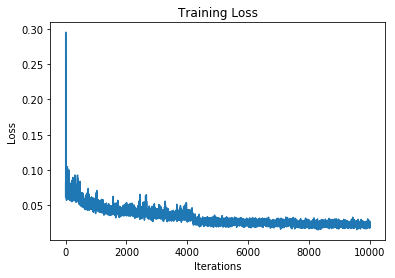

Final Training Accuracy: 35155/50000 (70.31%)
Final Training Loss: 0.30566


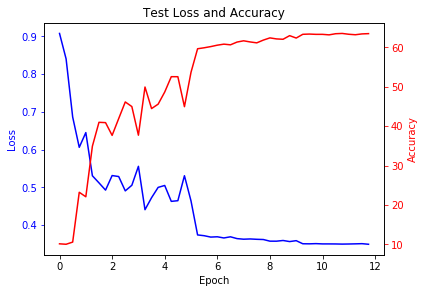

Final Test Accuracy: 6322/10000 (63.22%)
Final Test Loss: 0.34919


In [13]:
plt.title('Training Loss')
plt.plot(TrainLoss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()
print 'Final Training Accuracy: %d/%d (%.2f%%)' % (TrN,TrD,100*float(TrN)/TrD)
print 'Final Training Loss: %.5f' % (ftrain_loss)

statsIdx = range(len(TestLoss))
statsIdx = [float(c)/NUMSTATSPEREPOCH for c in statsIdx]


fig, ax1 = plt.subplots()
ax1.plot(statsIdx,TestLoss, 'b-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(statsIdx,TestAcc, 'r-')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()
plt.title('Test Loss and Accuracy')
plt.show()
print 'Final Test Accuracy: %d/%d (%.2f%%)' % (TN,TD,100*float(TN)/TD)
print 'Final Test Loss: %.5f' % (TestLoss[-1])


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


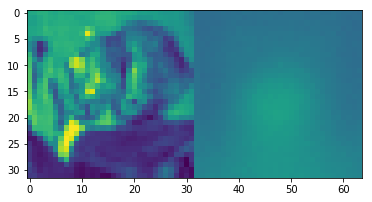

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


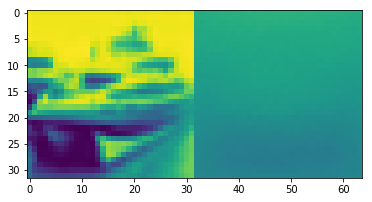

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


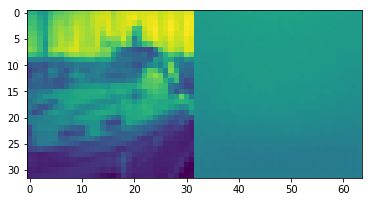

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


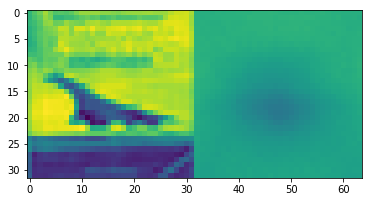

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


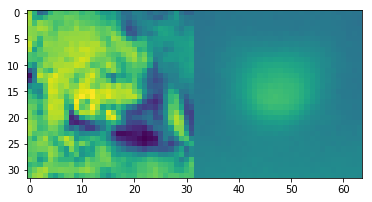

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


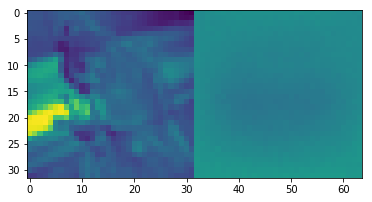

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


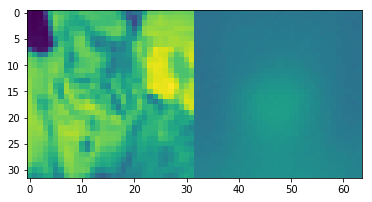

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


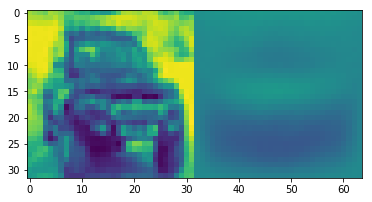

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


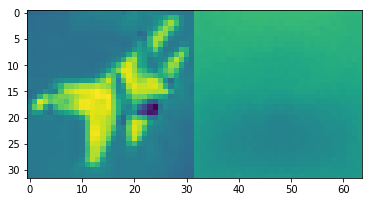

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


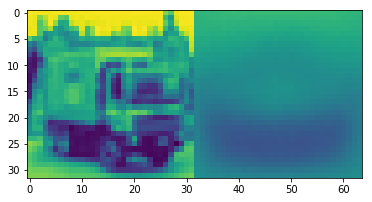

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


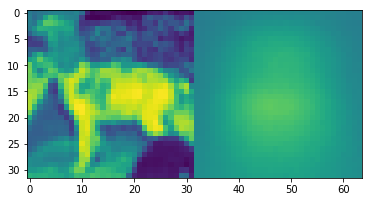

	Example: dog, Prediction: dog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


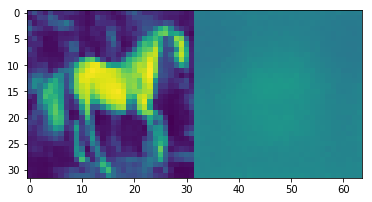

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


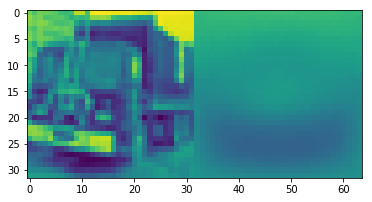

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


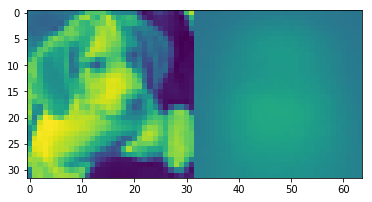

	Example: dog, Prediction: dog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


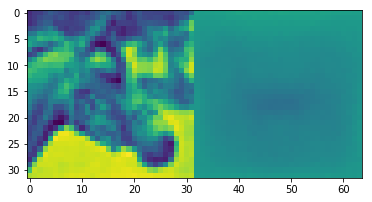

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


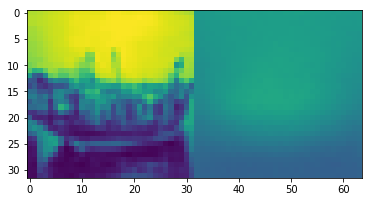

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


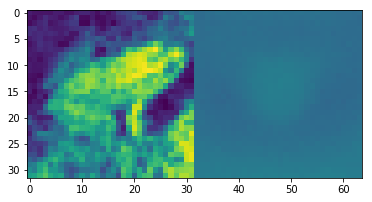

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


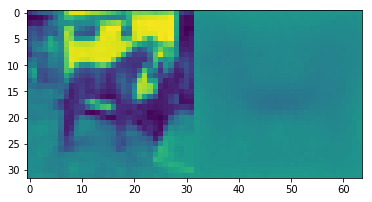

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


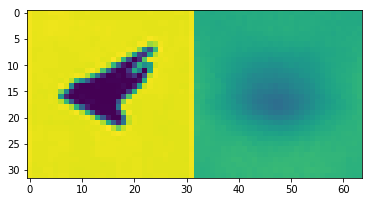

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


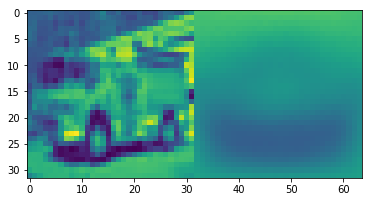

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


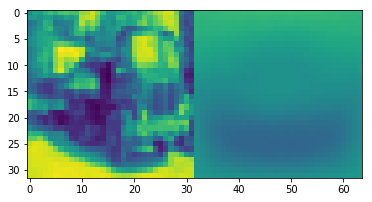

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


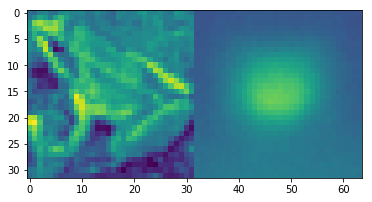

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


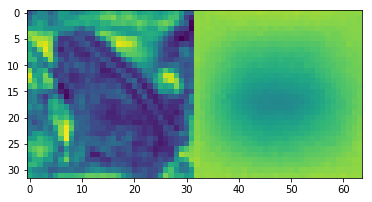

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


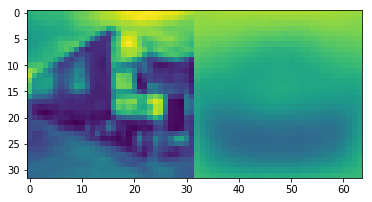

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


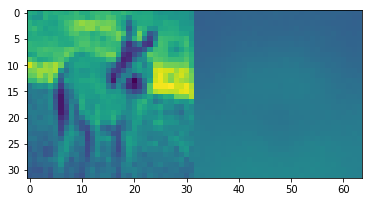

	Example: deer, Prediction: deer
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


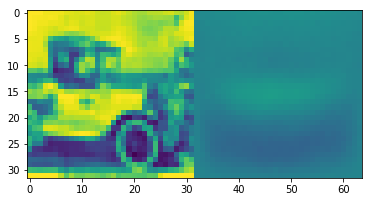

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


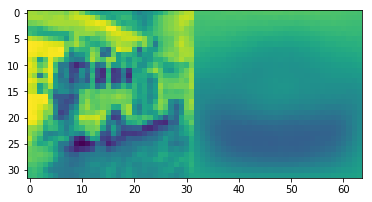

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


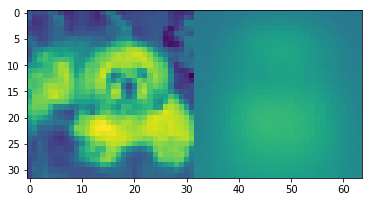

	Example: dog, Prediction: dog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


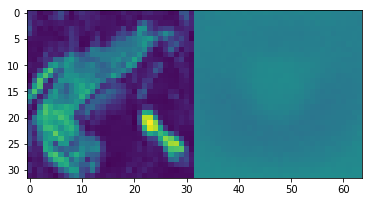

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


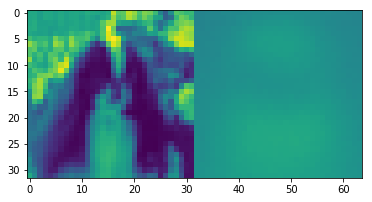

	Example: dog, Prediction: dog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


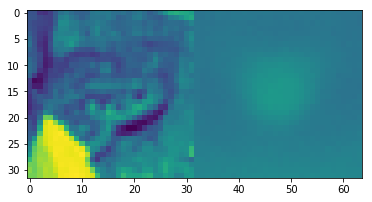

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


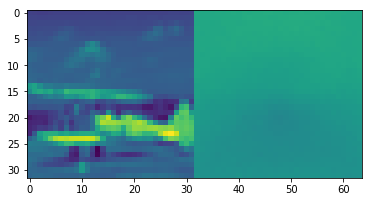

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


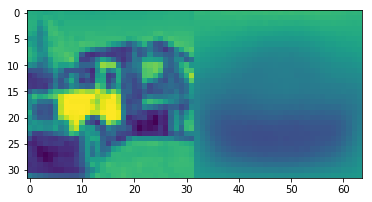

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


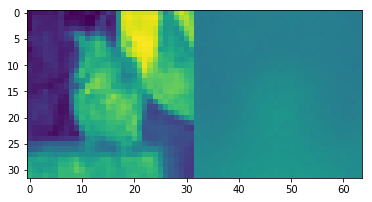

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


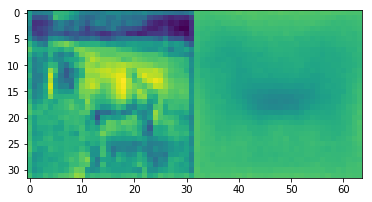

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


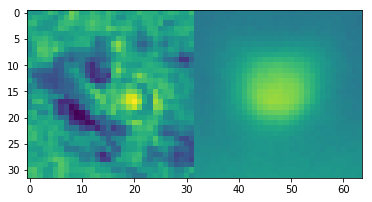

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


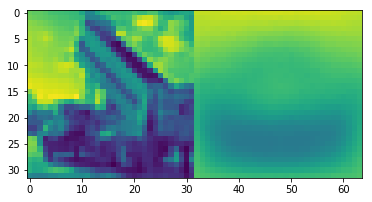

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


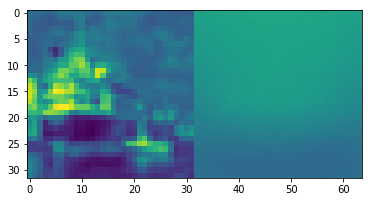

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


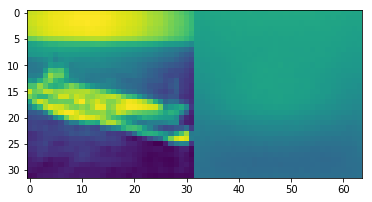

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


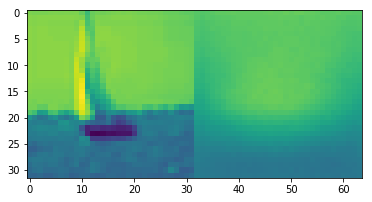

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


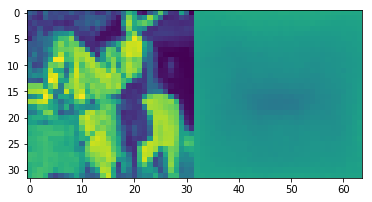

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


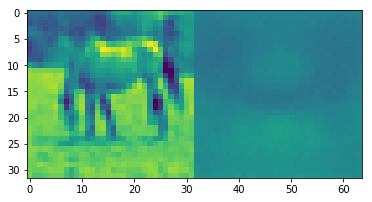

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


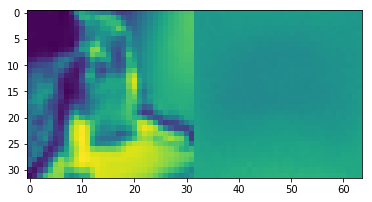

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


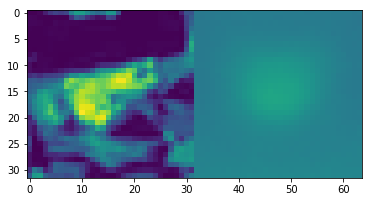

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


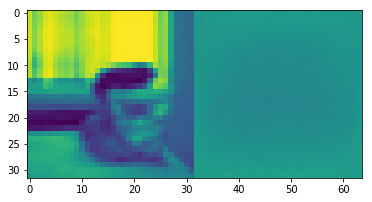

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


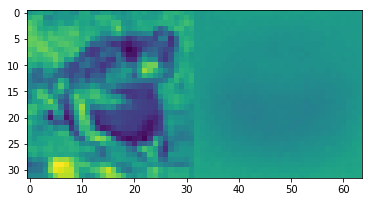

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


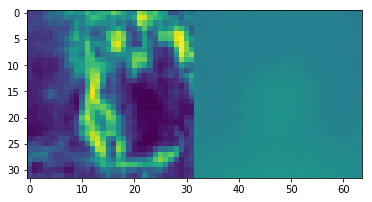

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


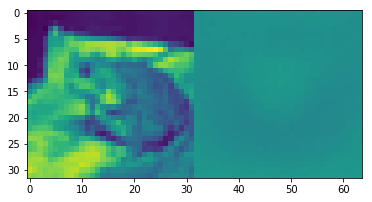

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


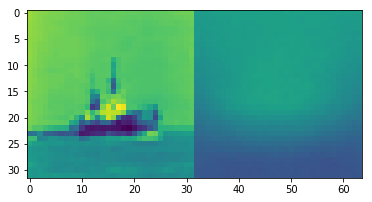

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


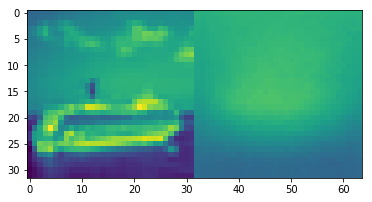

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


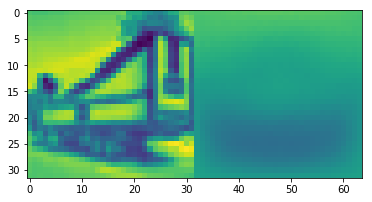

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


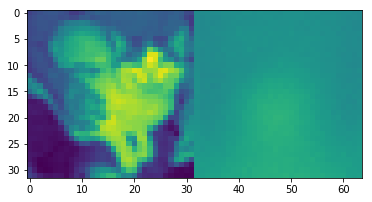

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


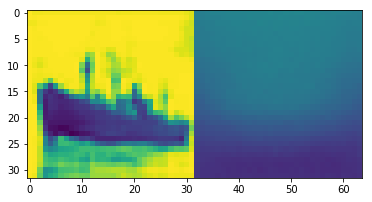

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


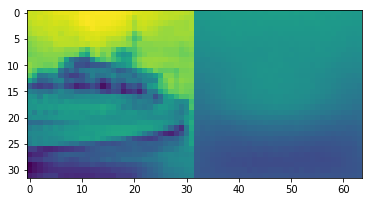

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


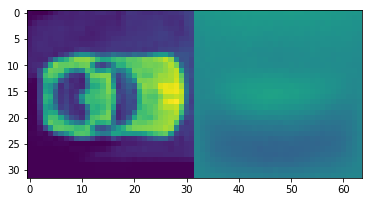

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


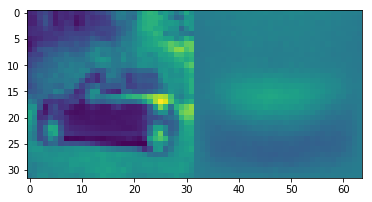

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


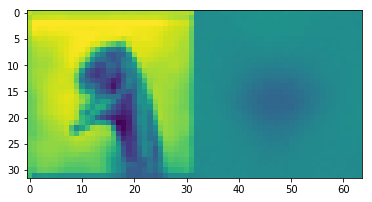

	Example: bird, Prediction: bird
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


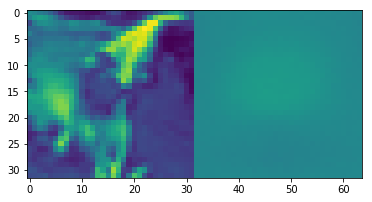

	Example: bird, Prediction: bird
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


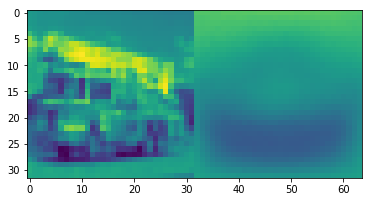

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


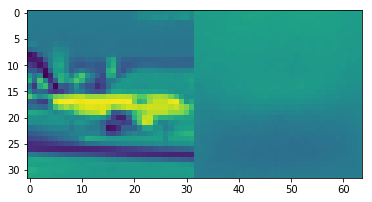

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


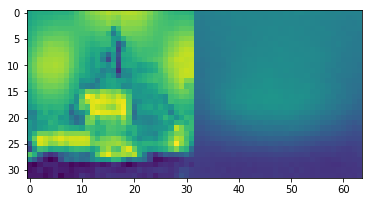

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


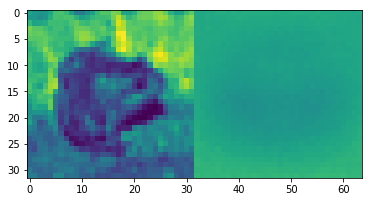

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


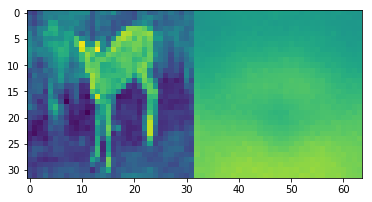

	Example: deer, Prediction: deer
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


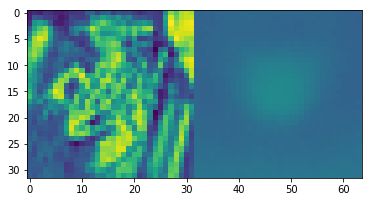

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


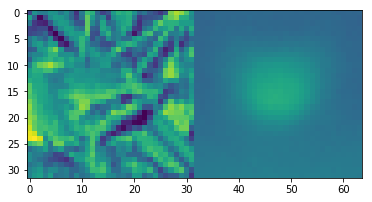

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


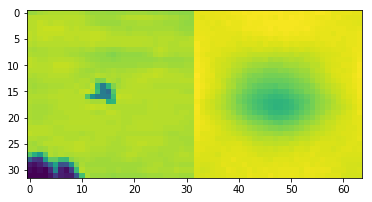

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


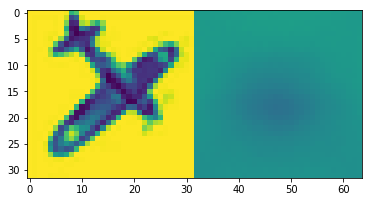

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


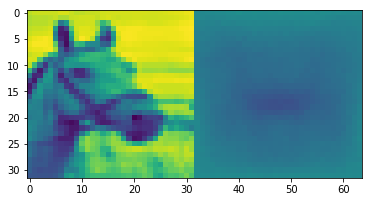

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


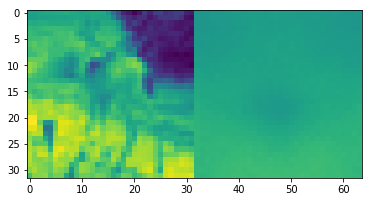

	Example: deer, Prediction: deer
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


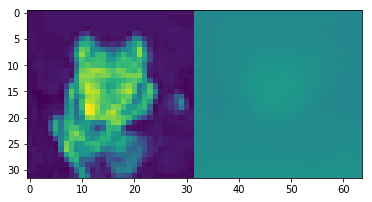

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


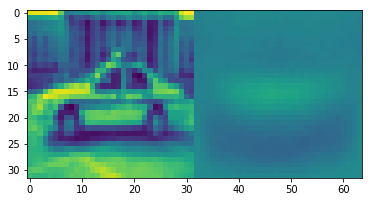

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


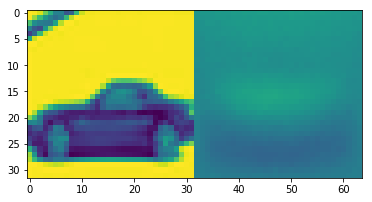

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


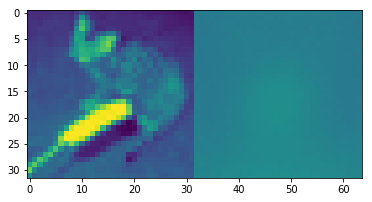

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


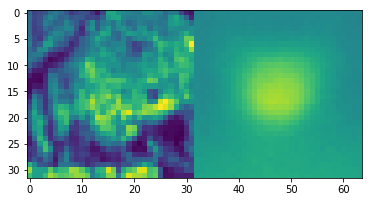

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


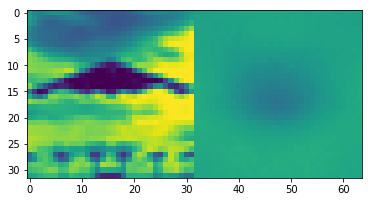

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


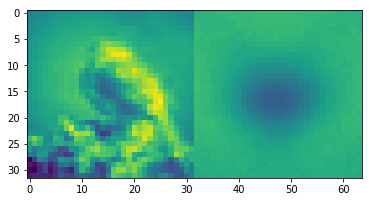

	Example: bird, Prediction: bird
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


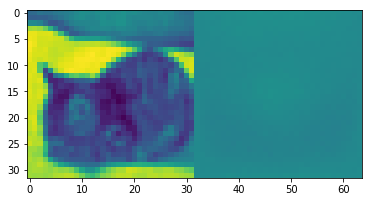

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


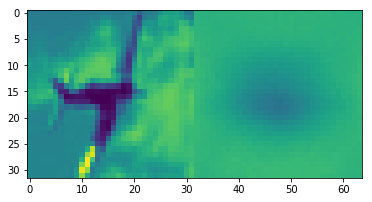

	Example: airplane, Prediction: airplane
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


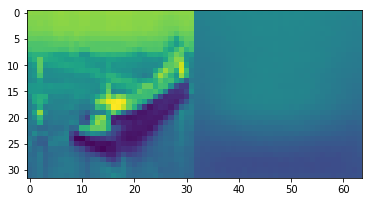

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


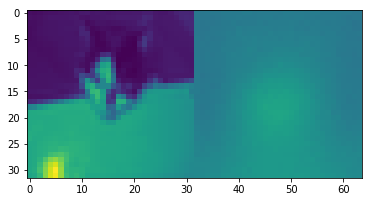

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


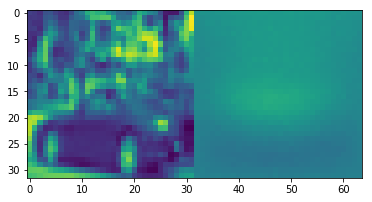

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


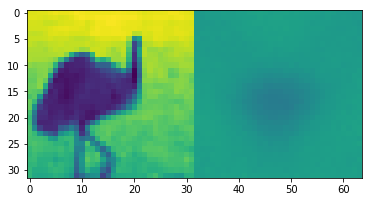

	Example: bird, Prediction: bird
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


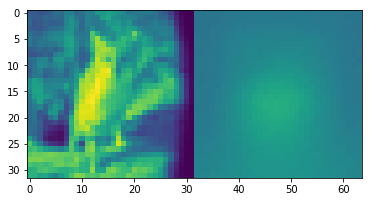

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


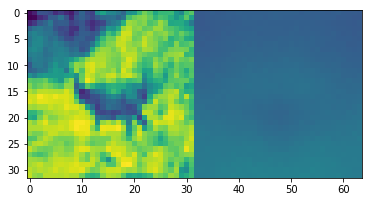

	Example: deer, Prediction: deer
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


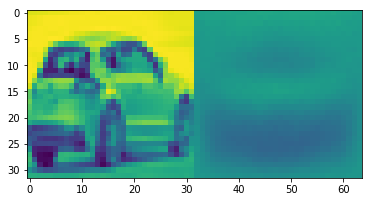

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


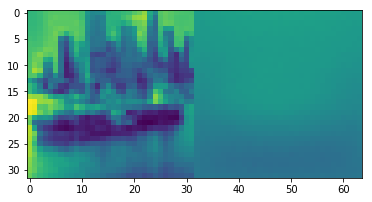

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


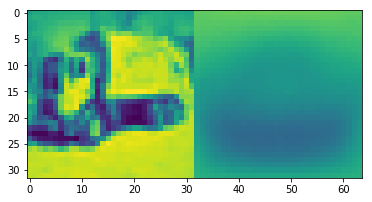

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


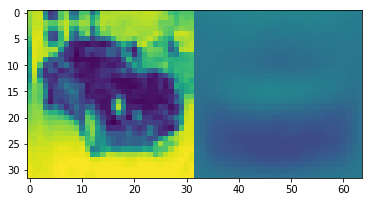

	Example: automobile, Prediction: automobile
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


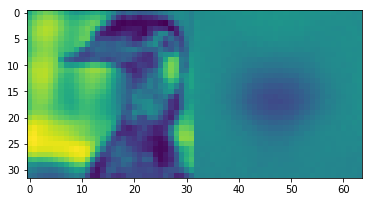

	Example: bird, Prediction: bird
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


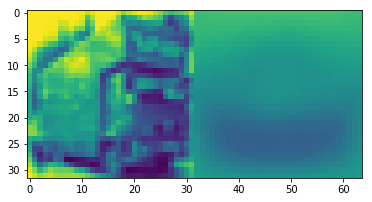

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


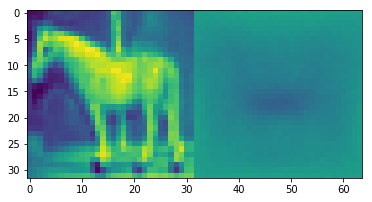

	Example: horse, Prediction: horse
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


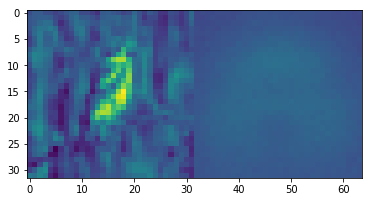

	Example: bird, Prediction: bird
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


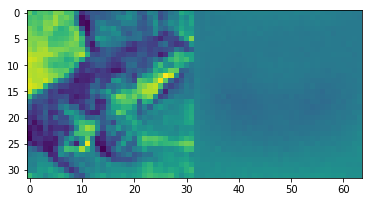

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


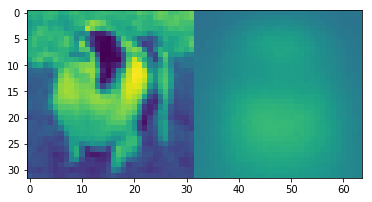

	Example: dog, Prediction: dog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


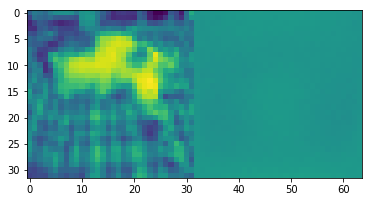

	Example: cat, Prediction: cat
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


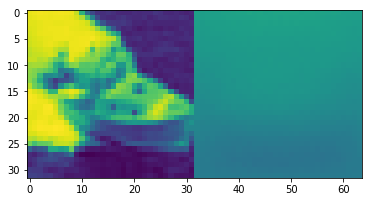

	Example: ship, Prediction: ship
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


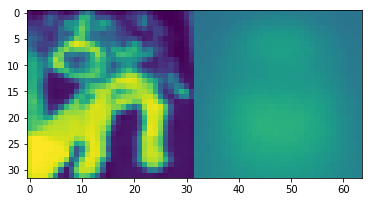

	Example: dog, Prediction: dog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


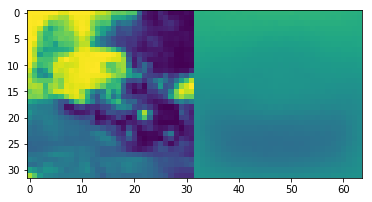

	Example: truck, Prediction: truck
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


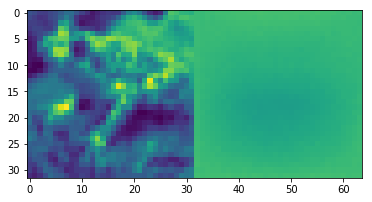

	Example: frog, Prediction: frog
_______________________________________________


	     INPUT 	 |  RECONSTRUCTION

Red Dimension:


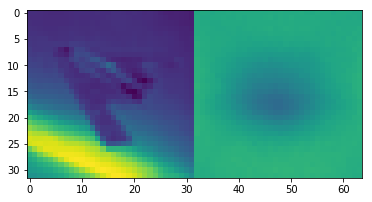

	Example: airplane, Prediction: airplane
_______________________________________________




In [39]:
lab2class = {0:'airplane',1:'automobile',2:'bird',3:'cat',
            4:'deer',5:'dog',6:'frog',7:'horse',
             8:'ship',9:'truck'}
def getWrongs(dataloader,numSamples):
    model.eval()
    numWrongs = 0
    for data, target in dataloader:
        data = data.view(-1,3,32,32)
        data, target = data.float(), target.long()
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, probs = model(data, target)
        output = output.view(200,3,32,32)
        output, probs = output.cpu().data.numpy(), probs.cpu().data.numpy()
        data = data.cpu().data.numpy()
        for ex in range(output.shape[0]):
            targ = target[ex].cpu().data.numpy()[0]
            pred = np.argmax(probs[ex,:])
            if pred == targ and numWrongs < numSamples:
                numWrongs += 1
                exImg = np.dstack((data[ex][0],data[ex][1],data[ex][2]))
                outImg = np.dstack((output[ex][0],output[ex][1],output[ex][2]))
                print '\t     INPUT \t |  RECONSTRUCTION'
                #plt.imshow(output[ex][0]); plt.show()
                #plt.imshow(np.concatenate((exImg,outImg), axis=1))
                print '\nRed Dimension:'
                plt.imshow(np.concatenate((data[ex][0],output[ex][0]), axis=1))
                plt.show()
#                 print 'Green Dimension:'
#                 plt.imshow(np.concatenate((data[ex][1],output[ex][1]), axis=1))
#                 plt.show()
#                 print 'Blue Dimension:'
#                 plt.imshow(np.concatenate((data[ex][2],output[ex][2]), axis=1))
#                 plt.show()
                print '\tExample: %s, Prediction: %s' % \
                    (lab2class[targ],lab2class[pred])
                print '_______________________________________________\n\n'
                

            
getWrongs(TESTLOADER,100)